In [1]:
import numpy as np
import pandas as pd

# import plotting libraries to explore the data
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
import seaborn as sns;

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# for debuging
from datetime import datetime

<h3>Part 1 - Importing the data</h3>
<p>In part one of the project we have already filter the data and explored it, [link to part one : ]
    So here we can just input the finalized csv file with all the aggregated information.
    <br />
    I thought I found all the data in part 1, but when started to anlyze it I found out we have few problems.
    Some of the categories in the data were just Food / Resturants which doesn't gives us a lot of informaiton.
    In total there were almost 8000 places like those which is hard to fill out by hand; So I decided to look throw the data already existing to check if some of the places exists in other location with more information.
    It did worked and I managed to fill out almost a 1,000 of those missing points.
    Decided to remove the rest to prevent baised results. I think I can live with missing 7K locations out of 150K (4% so it's still arguable :))
</p>

In [2]:
# import CSV
aggregated_venues_df = pd.read_csv('aggregated_venues.csv')
zipcodes_df = pd.read_csv('grouped_zipcodes.csv')

In [3]:
print('Venues shape: ', aggregated_venues_df.shape)
print('ZipCode shape: ', zipcodes_df.shape)

Venues shape:  (151065, 6)
ZipCode shape:  (29994, 7)


<h3>Part 2 - Analysing our data</h3>
<p>
    Before clustering the data we have to create a dummies data frame since our data is categorical.
    We can explore the most frequent places by summing up by zip code and sorting by the frequancy.
    <br />
    I checked this data both in general and per state for comparcment to check if there are any differances between the states
</p>

In [4]:
# create a new data frame with groupped venues
# one hot encoding
dummies = pd.get_dummies(aggregated_venues_df[['Restaurant Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dummies['ZipCode'] = aggregated_venues_df['ZipCode'] 

# move zipcide column to the first column
fixed_columns = [dummies.columns[-1]]  + dummies.columns[:-1].to_list()
dummies = dummies[fixed_columns]

print(dummies.shape)
dummies.tail()

(151065, 184)


,ZipCode,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
151060,65689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151061,65689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151062,65689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151063,65689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151064,65689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# check for a corrleaction between the data
data_corr = dummies.groupby('ZipCode').mean().reset_index().drop('ZipCode',1)

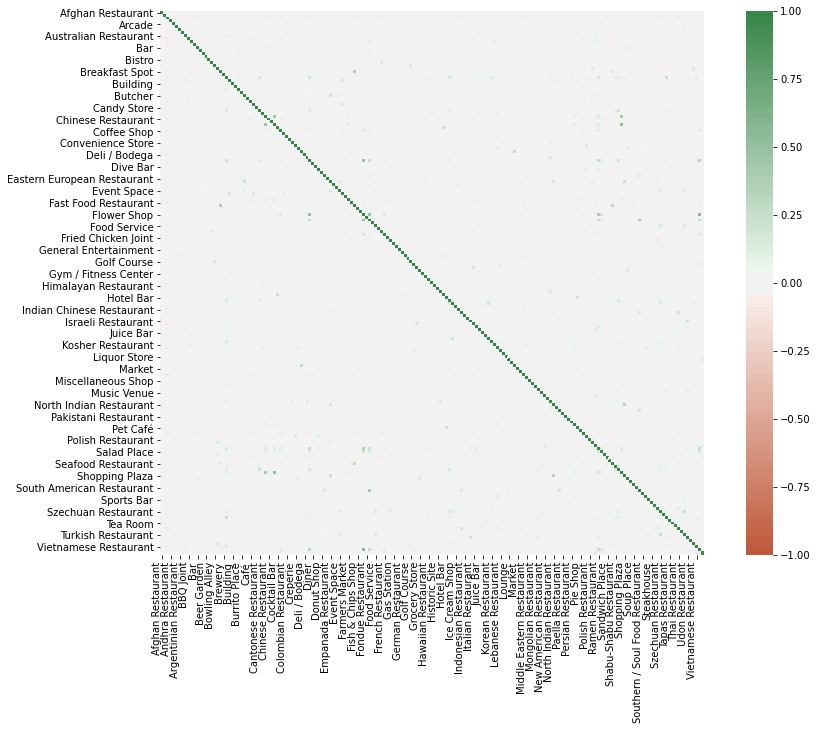

In [6]:
# run corrlaction between all features - full db
#plot corrolation graph

def Plot_Correlation(df):
    import seaborn as sns
    temp = df
    plt.subplots(figsize=(15,10))
    corr = temp.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(22, 133 , n=200),
        square=True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right');

Plot_Correlation(data_corr)

In [7]:

c = data_corr.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

# corrlacted values above 0.5 below 1 (- if values are 1 it's the same)
so[np.where((so < 1) & (so > 0.5))[0]].sort_values(ascending=False)

Flower Shop         Wine Bar              0.547611
Wine Bar            Flower Shop           0.547611
Shopping Mall       Churrascaria          0.518713
Churrascaria        Shopping Mall         0.518713
Dim Sum Restaurant  Flower Shop           0.505529
Flower Shop         Dim Sum Restaurant    0.505529
dtype: float64

<p>
As we have expected the data has no significant correlation between the different categories.
<br/>
In the next step we will be looking at the most frequant location by zip codes
</p>

In [8]:
number_of_top_reseturants = 15

# create columns according to number of top venues
columns = ['ZipCode']
indicators = ['st', 'nd', 'rd']
for ind in np.arange(number_of_top_reseturants):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# loop throw the data and sort by freq
def sort_by_freq(df):
    return pd.Series(
        [row[0] , *row[1:].sort_values(ascending=False).index.values[0:number_of_top_reseturants]]
        for index, row in df.iterrows()
    )

In [9]:
neighborhoods_venues_sorted = pd.DataFrame()
def generate_ven_sorted():
    # import pd series to data frame
    res_grouped = dummies.groupby('ZipCode').mean().reset_index()
    res = sort_by_freq(res_grouped)

    neighborhoods_venues_sorted = pd.DataFrame.from_records(res)
    neighborhoods_venues_sorted.columns=columns
    return neighborhoods_venues_sorted

neighborhoods_venues_sorted = generate_ven_sorted()
neighborhoods_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,501.0,American Restaurant,Deli / Bodega,Coffee Shop,Breakfast Spot,Food Truck,Latin American Restaurant,Comfort Food Restaurant,Diner,Dim Sum Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Dessert Shop,Farmers Market,Falafel Restaurant
1,544.0,American Restaurant,Deli / Bodega,Coffee Shop,Breakfast Spot,Food Truck,Latin American Restaurant,Comfort Food Restaurant,Diner,Dim Sum Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Dessert Shop,Farmers Market,Falafel Restaurant
2,1001.0,Bakery,Diner,Pizza Place,Donut Shop,Ice Cream Shop,Italian Restaurant,Chinese Restaurant,Empanada Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant
3,1002.0,Pizza Place,Convenience Store,Coffee Shop,Donut Shop,Bagel Shop,Ramen Restaurant,Food Truck,French Restaurant,Sushi Restaurant,Bakery,Chinese Restaurant,Middle Eastern Restaurant,Sandwich Place,Diner,Dessert Shop
4,1003.0,Deli / Bodega,Coffee Shop,Café,Sandwich Place,BBQ Joint,Wings Joint,English Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,Eastern European Restaurant,Empanada Restaurant


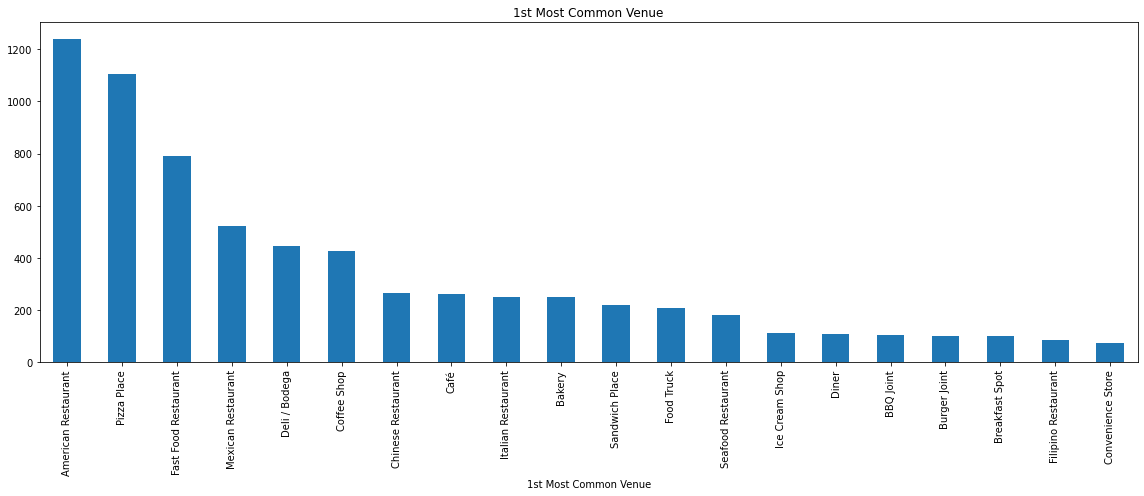

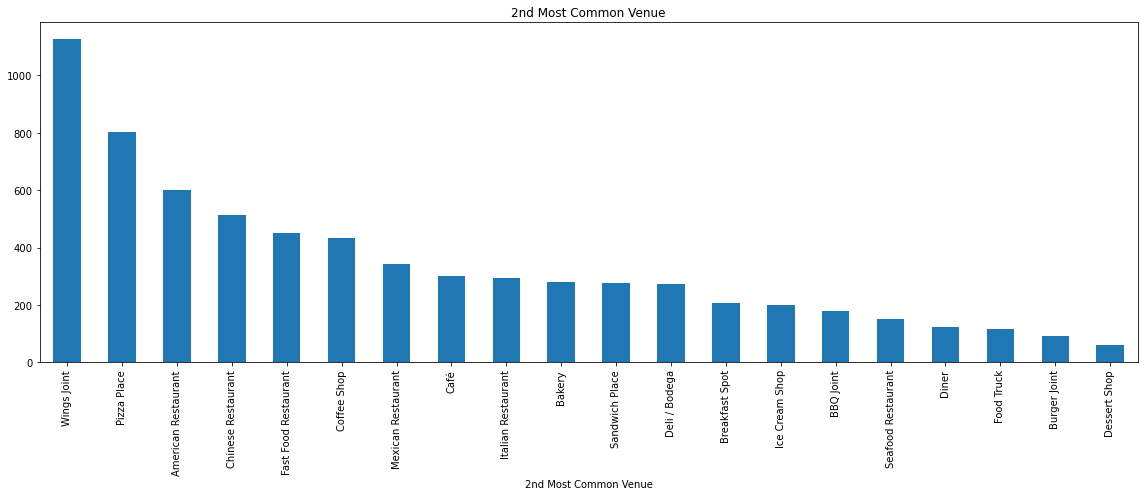

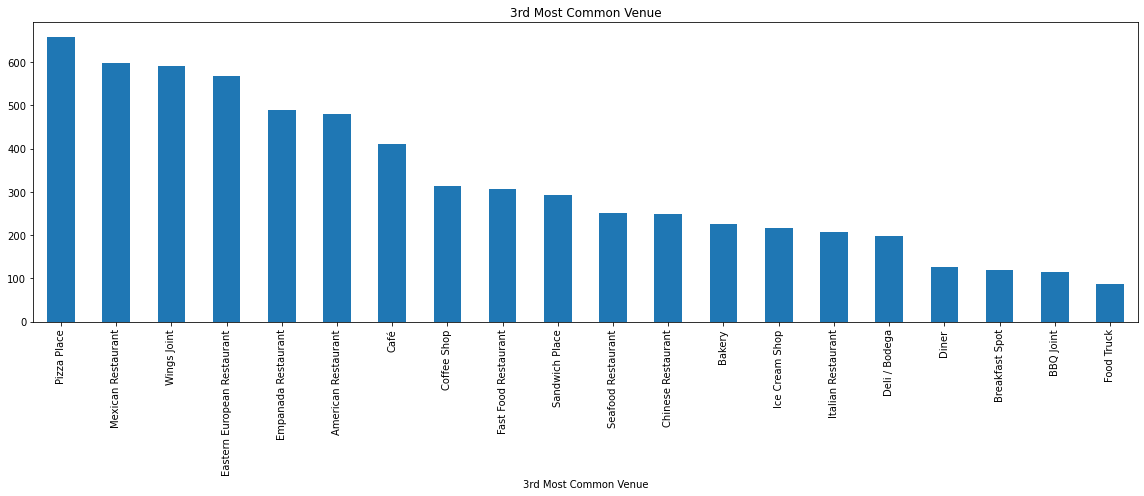

In [10]:
# plot 3 most common places on a plot
def plot_most_freq(cat):
    fig = plt.figure(figsize=(16,7))
    plt.title(cat)
    neighborhoods_venues_sorted[['ZipCode', cat]].groupby(cat).size().sort_values(ascending=False).head(20).plot.bar()
    plt.tight_layout()
    
    # save the figure
    fig.savefig(cat + '.png', bbox_inches='tight')

plot_most_freq('1st Most Common Venue')
plot_most_freq('2nd Most Common Venue') 
plot_most_freq('3rd Most Common Venue')

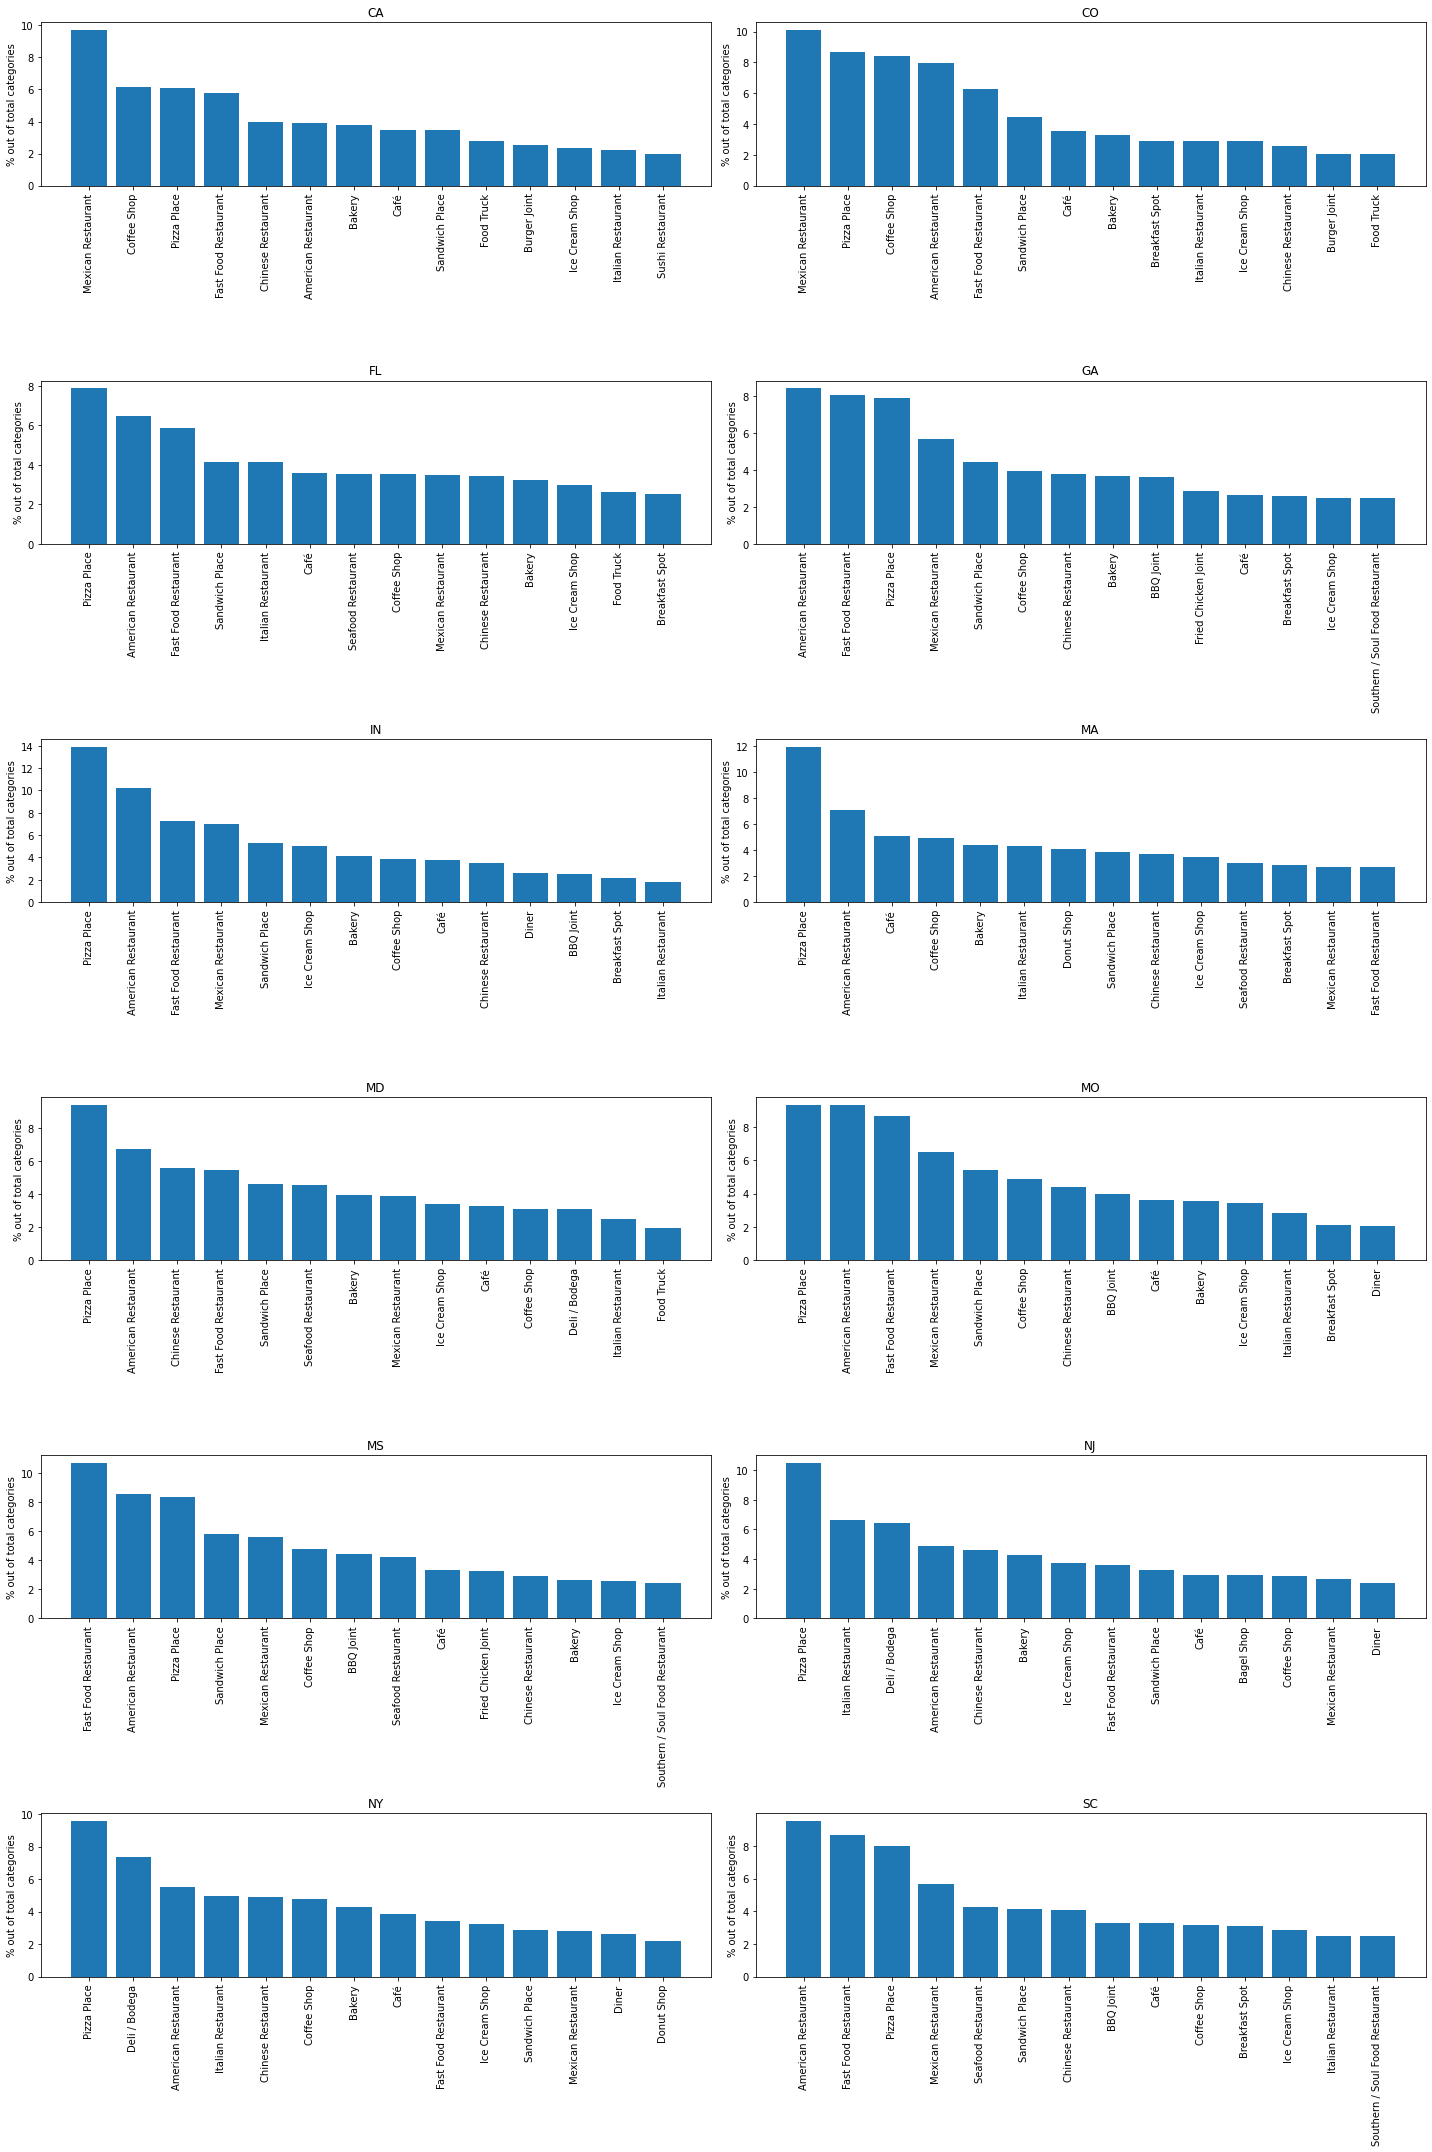

In [11]:
# marging with state data

temp = zipcodes_df[['Zip', 'State',]]
dummies_state_df = pd.merge(left=dummies, right=temp, how='left', left_on='ZipCode', right_on='Zip')
grouped_state = dummies_state_df.groupby('State').mean().reset_index()
# call the freq function

# loop throw the data and sort by state, freq, name of locaiton
def sort_by_freq_name(df):
    return pd.Series(
        [row[0] , 
         *row[1:].sort_values(ascending=False)[0:number_of_top_reseturants], 
         *row[1:].sort_values(ascending=False).index.values[0:number_of_top_reseturants]]
        for index, row in df.iterrows()
    )

res = sort_by_freq_name(grouped_state.drop(['ZipCode', 'Zip' ],1))

fig = plt.figure(figsize=(20,30))
# create a 2 columns plot for each state
for i in range(0, len(res)):
    row = res[i]
    fig.add_subplot(6,2,i+1)
    plt.title(row[0])
    x = row[number_of_top_reseturants+1:-1]
    height = np.array(row[1:number_of_top_reseturants]) * 100
    plt.xticks(rotation=90) 
    plt.ylabel('% out of total categories')
    plt.bar(x, height, width=0.8)
    plt.tight_layout()

plt.show()
fig.savefig('states_freq.png', bbox_inches='tight')

<h3>Part 3 : Clustering the data</h3>
<p>
    To analyse the data I want to try and segment the zip code using kmeans algorithem.
    This algorithm takes our restaurants information for each zip code and tries to segment them into different clusters - a cluster is a group of items that are share some similarity.
       
    The biggest question is to how many cluster we should segment them into. One way to do it is just try different numbers by manually until we are satisfied with the result and we can understand the differance between the clusters. for eaxmple clust 1 is coffe shop and cluster 2 is fast food restaurants and etc.
    
    Another way is to split our data is using a clustering and do some features selctions, or just manully.
    So manully I started up with 5 cluster which made it hard to understand the difference between them, cluster 4 and 1 both shares Pizza as their top place.
    [Image]
    Trying with a height number, I tried with 8 gave a much better result been more diffrintiate between the food types. Same problem here cluster 2(3- counting by leading zeros), share pizza with cluster 7 but it's a very small cluster and we can just combine them and we are still left with 7 different clusters.
    
    Next step is to calculate our fitting scores and check the results.
    [Add a summery table]
    To check the efficiency of our algorithem we can use two diffrent matrixed and calculated the result for number of different clusters sizes
    
    The simplest thing to do is to use the Kmeans built in scoring a params named inertia_, we want to find the point where this number goes down and start to convearge.
    
    Another score we can use is silhouette_score from sklearn, this score is very usfull when working with clustering, it calculates the distance between clusters and tell us how far away they are from each other. Thec score of this algorithem will range from -1 to 1, where a score of -1 means something is wrong, 0 they are not on top of each other but pretty close and a score as close to 1 means they are far away.
    Here is a great post the explains this scoring https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
    
    Our data heights Silhouette score is around 0.4 with 3 clustes, not the best results.
    Next we will use a different clustering algorithem called DBSCAN also part of Sklearn package.
</p>

<h5>Manully clustering the data:</h5>
<p>
    This is not the smartest way, but this can help understand how the data looks and how increasing or decreasing the number of cluster can influence our results.
</p>

In [12]:
## define the clustering data
X = dummies.groupby('ZipCode').mean().reset_index()
X_raw = X.drop('ZipCode', 1)
print(X_raw.shape)

## define a function that will help us print the 3 most common places in each cluster
def clusters_data(cluster_label, df):
    temp = df.groupby([cluster_label, '1st Most Common Venue']).size().sort_values(ascending=False).reset_index()
    temp_df = pd.DataFrame(temp)

    summary_df = pd.DataFrame()
    for i in range(0, k):
        summary_df = pd.concat([summary_df, temp_df[temp_df[cluster_label] == i].head(3)])

    summary_df.columns = ['Cluster', 'Restaurants', 'Count']
    summary_df.groupby(['Cluster', 'Count']).head()
    
    return summary_df

(7851, 183)


In [13]:
# clustering the data

neighborhoods_venues_sorted = generate_ven_sorted()

# set number of clusters
k = 8

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=4, n_init=10).fit(X_raw)

# add result to DF and attach top venues
print('Number of clusters', np.unique(kmeans.labels_))
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_merged = aggregated_venues_df.join(neighborhoods_venues_sorted.set_index('ZipCode'), on='ZipCode')

df_merged.head()

Number of clusters [0 1 2 3 4 5 6 7]


,ZipCode,Restaurant Name,Restaurant Distance,Restaurant Latitude,Restaurant Longitude,Restaurant Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,92067,Morada Restaurant Santa Fe,333,33.018589,-117.205193,American Restaurant,0,American Restaurant,Burger Joint,Coffee Shop,...,BBQ Joint,Empanada Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant
1,92067,Thyme In the Ranch,300,33.019136,-117.203267,Tea Room,0,American Restaurant,Burger Joint,Coffee Shop,...,BBQ Joint,Empanada Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant
2,92067,Rancho Sandwich,374,33.019840,-117.203076,Sandwich Place,0,American Restaurant,Burger Joint,Coffee Shop,...,BBQ Joint,Empanada Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant
3,92067,Osuna Grill,1054,33.023982,-117.209560,Burger Joint,0,American Restaurant,Burger Joint,Coffee Shop,...,BBQ Joint,Empanada Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant
4,92067,Caffe Positano,393,33.019999,-117.203176,Coffee Shop,0,American Restaurant,Burger Joint,Coffee Shop,...,BBQ Joint,Empanada Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair,Event Space,Ethiopian Restaurant,English Restaurant


In [14]:
res = clusters_data('Cluster Labels', df_merged)
pivoted = res.pivot(index='Restaurants', columns='Cluster', values='Count')
pivoted[pd.isnull(pivoted)] = ''
pivoted

Cluster,0,1,2,3,4,5,6,7
Restaurants,,,,,,,,
African Restaurant,,,,,,2,,
American Restaurant,14808,41,,10,664,,,2323
Bakery,,,,,8,,,
Burger Joint,,,,,10,,,
Café,,353,,,,,,
Chinese Restaurant,,,,,,131,,
Deli / Bodega,,,,,,,118,6356
Diner,,,,115,,,,
Fast Food Restaurant,20042,45,,,,,,


<h5>Kmeans</h5>
<p>Defining our data set and a training algorithm for kmeans - the goal is to find the best number of clusters by scoring the result</p>

In [15]:
## define a function to run test on Kmeans

# X - values to run algo on
# s_value - the min value the loop will start from
# e_value - the maximm value to go to
# plot_name - optional param to save plot to image
def test_kmeans(df, s_value, e_value, plot_name = None):
    scores = []
    silhouette_coefficients_means = []
    x_range = range(s_value, e_value)

    for k in x_range:
        kmeans = KMeans(n_clusters=k, random_state=40, n_init=12)
        kmeans.fit(df)
        scores.append(kmeans.inertia_)
        if(len(np.unique(kmeans.labels_)) > 2 and len(np.unique(kmeans.labels_)) < len(df)):
            silhouette_coefficients_means.append(silhouette_score(df, kmeans.labels_))
        else:
            silhouette_coefficients_means.append(-2)
    
    fig = plt.figure(figsize=(8,5))
    # ploting the result 
    plt.subplot(1,2,1)
    plt.plot(x_range, scores)
    plt.xticks(x_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")

    plt.subplot(1,2,2)
    plt.plot(x_range, silhouette_coefficients_means)
    plt.xticks(x_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette coef")
    
    plt.tight_layout()
    plt.show()
    
    # find the best number of clusters
    loc = np.where(silhouette_coefficients_means == np.max(silhouette_coefficients_means))[0][0]
    print('Best Kmeans coeff {} at K= {}'.format(np.max(silhouette_coefficients_means), x_range[loc]))
    
    if plot_name is not None:
        # save plot
        fig.savefig(plot_name, bbox_inches='tight')
        
    return x_range[loc]

<b>DBSCAN</b>

<p>
    Since our data doesnt fit very well using Kmeans algorithem I decided to use a different algorithem.
    DBSCAN is a clustering algorithem that works without us specific telling how many clusters we want. the algorithem calculates the distance between the data points and try to segment them into clusters based on this distance.
    We can specify the distance we want by setting the eps params, we can also set the min number of samples that are need to form a cluster.
    The algorithm support more params as can be learned using the officical documentation.
</p>

<code>
from sklearn.cluster import DBSCAN
#grouped_clustering - this is my input data
    
x_range = np.arange(0.1,1,0.1)
silhouette_coefficients = []

for e in x_range:
    clustering = DBSCAN(eps=e, min_samples=100).fit(grouped_clustering)
    silhouette_coefficients.append(silhouette_score(grouped_clustering, clustering.labels_))

# ploting the result 
plt.plot(x_range, silhouette_coefficients)
plt.xticks(x_range)
plt.xlabel("EPS value")
plt.ylabel("Silhouette coef")

plt.show()
</code>

<p>
    The result of the DBSCAN algorithem with different params doesn't do a lot better then the Kmeans algorithem in this case.
    <br />
    Kmeans results are 0.396
    DBSCAN results are 0.45
    <br />
    I applied the results of both algorithem to our data set and checked if it was clustered in the same way. checking which categories fall under each cluster.
    Manully chosing the one that seems more segmented to me
</p>

In [16]:
## define a function to run test on Kmeans

# X - values to run algo on
# s_value - the min value the loop will start from
# e_value - the maximm value to go to
# steps - optional to set the steps range
# plot_name - optional param to save plot to image
def test_dbsacn(X, s_value, e_value, steps = 0.1, plot_name = None):

    # using eps of 0.8 gives a score of 0.45.. 
    x_range = np.arange(s_value,e_value,steps)
    silhouette_coefficients = []

    for e in x_range:
        clustering = DBSCAN(eps=e, min_samples=9).fit(X)
        if(len(np.unique(clustering.labels_)) > 2 and len(np.unique(clustering.labels_)) < len(X)):
            silhouette_coefficients.append(silhouette_score(X, clustering.labels_))
        else:
            silhouette_coefficients.append(-2)

    # ploting the result 
    fig = plt.figure(figsize=(8,5))
    plt.plot(x_range, silhouette_coefficients)
    plt.xticks(x_range)
    plt.xlabel("EPS value")
    plt.ylabel("Silhouette coef")
    plt.tight_layout()
    plt.show()

    loc = np.where(silhouette_coefficients == np.max(silhouette_coefficients))[0][0]
    print('Best DBSCAN coeff {} at eps= {}'.format(np.max(silhouette_coefficients), x_range[loc]))
                                                   
    if plot_name is not None:
        # save plot
        fig.savefig(plot_name, bbox_inches='tight')
        
    return x_range[loc]

In [17]:
## function to run the test
## preffered to write a single function to avoid variables confussion

def print_dbscan_state(db_cluster, df):
    # Number of clusters in labels, ignoring noise if present.
    labels = db_cluster.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score_ = -2
    
    if(len(np.unique(labels)) > 2 and len(np.unique(labels)) < len(df)):
        score_ = silhouette_score(df, labels)
    
    print('Estimated number of clusters dbs: %d' % n_clusters_)
    print('Estimated number of noise points dbs: %d' % n_noise_)
    if(score_ > -2):
        print("Silhouette Coefficient dbs: %0.3f" % score_)
    
    return n_clusters_, n_noise_, score_

def retrive_result(df, best_k, best_eps):
    ## cluster the data using both algorithem
    neighborhoods_venues_sorted = generate_ven_sorted()
    ## clustering using Kmeans 
    # based on our anlysis k gives the best result with 3 clusters
    kmeans = KMeans(n_clusters=best_k, random_state=40, n_init=12).fit(df)
    k_score_ = -2
    # find s_ci scroe for kmeans
    if(len(np.unique(kmeans.labels_)) > 2 and len(np.unique(kmeans.labels_)) < len(df)):
        k_score_ = silhouette_score(df, kmeans.labels_)

    ## cluster using DBSCAN
    # based on our anlysis we found that 0.7 gives the best results
    dbscan = DBSCAN(eps=best_eps, min_samples=9).fit(df)
    
    # test the best score we found using pca data fro dbscan
    d_clusters_, d_noise_, d_score_ = print_dbscan_state(dbscan, df)

    # add clustering labels to our dataframe
    neighborhoods_venues_sorted.insert(0, 'Kmeasn clusters', kmeans.labels_)
    neighborhoods_venues_sorted.insert(0, 'DBSCAN clusters', dbscan.labels_)

    # merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
    df_merged_pca = aggregated_venues_df.join(neighborhoods_venues_sorted.set_index('ZipCode'), on='ZipCode')
    
    ## aggregate result into one DF
    res_df = pd.DataFrame();
    
    ## check clusters data for kmeans
    temp =  clusters_data('Kmeasn clusters', df_merged_pca)
    temp.insert(0, 'algo', ['kmeans' for _ in range(len(temp))])
    res_df = pd.concat([res_df, temp])
    ## check clusters data for dbscan
    temp = clusters_data('DBSCAN clusters', df_merged_pca)
    temp.insert(0, 'algo', ['dbscan' for _ in range(len(temp))])
    res_df = pd.concat([res_df, temp])
    
    return res_df, d_clusters_, d_noise_, d_score_, k_score_


def run_benchmark(df, test_name):
    # test algorithems using pca data
    best_eps = test_dbsacn(df, 0.1, 1, steps = 0.1, plot_name='{}_dbsacn'.format(test_name))

    # run kmeans test
    best_k = test_kmeans(df, 2, np.min([20, len(df)]), '{}_kmeans'.format(test_name))
    
    print('test printing: eps={}, k={}'.format(best_eps, best_k))
    
    ## retrive result of best estimators
    res, d_clusters_, d_noise_, d_score_, k_score_ = retrive_result(df, best_k, best_eps)
    
    return res, [test_name, best_eps, d_clusters_, d_noise_, d_score_, best_k, k_score_]

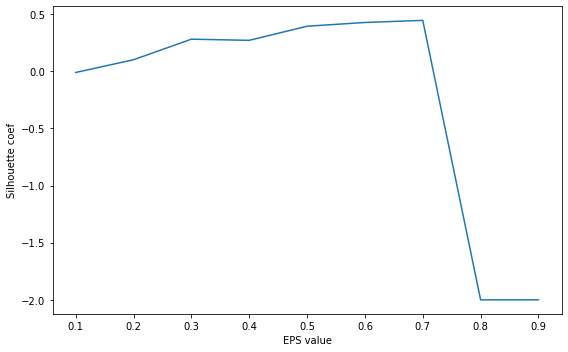

Best DBSCAN coeff 0.44582086306978175 at eps= 0.7000000000000001


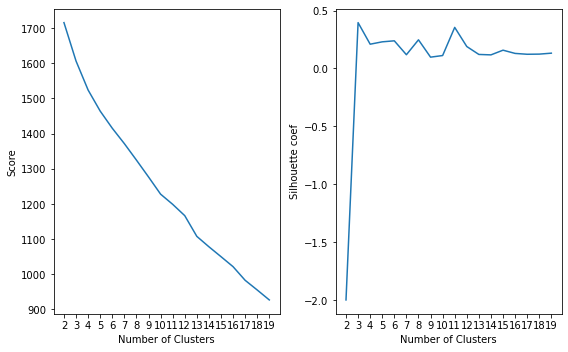

Best Kmeans coeff 0.3960288261317106 at K= 3
test printing: eps=0.7000000000000001, k=3
Estimated number of clusters dbs: 4
Estimated number of noise points dbs: 79
Silhouette Coefficient dbs: 0.446


,algo,Cluster,Restaurants,Count
0,kmeans,0,Pizza Place,24256
1,kmeans,0,Fast Food Restaurant,20808
2,kmeans,0,American Restaurant,17103
20,kmeans,1,American Restaurant,779
76,kmeans,1,Burger Joint,10
77,kmeans,1,Bakery,8
47,kmeans,2,Chinese Restaurant,141
78,kmeans,2,Ice Cream Shop,8
90,kmeans,2,Fast Food Restaurant,4
0,dbscan,0,Pizza Place,24256


In [18]:
raw_res_df, raw_res_results = run_benchmark(X_raw, 'raw_test')
raw_res_df

<h4>PCA</h4>
<p>
    The result doesn't satisfiying and the clustering seems very general.
    I want to try and use the PCA algorithem to reduce the data dimensionality.
    Using this algorithem we can find which features best describe our data.
    <br />
    With the location data I have, it seems like 65 features our of 183 can explain more them 95%
    The next step is to run the same kmeans and dbscan test algorithems but on the pca data.
    We can then comapare the result
    
    Another thing that I'm going to try it's to segment the data with the other PCA params.
    The resoan for that I'm trying to find a hidden pattern and if every city/zip code has a coffe shop maybe this is a baised result
</p>

95% of our data can be explanied using 44 feaures


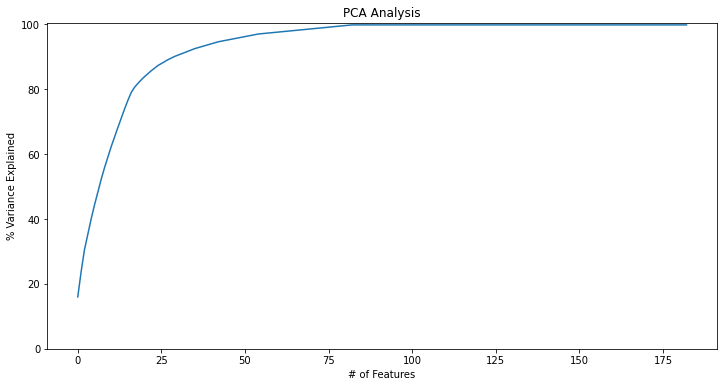

In [19]:
# runing pca algorithem on our dummies data 
# using the algorithem to find out which or more accurately how many featurees we need to explain 95% of our data
from sklearn.decomposition import PCA

pca = PCA(n_components=183)
pca.fit(X_raw)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)

fig = plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)
fig.savefig('pca_plot.png', bbox_inches='tight')
# find the number of components explanins 95% and above
com95 = np.where(var > 95)[0][0]
print('95% of our data can be explanied using {} feaures'.format(com95))

In [20]:
print('columns that found to be not relevant')
# sum up dummins by those columns
# crate an summary dataframe
pca_removed = dummies[X.columns[com95:]].sum(axis=0).reset_index()
pca_removed.columns = ['Category', 'Sum']
pca_removed.sort_values(by='Sum', ascending=False)

columns that found to be not relevant


,Category,Sum
99,Pizza Place,11934
21,Fast Food Restaurant,8221
79,Mexican Restaurant,8051
107,Sandwich Place,5539
62,Italian Restaurant,5098
...,...,...
66,Karaoke Bar,11
91,Other Nightlife,11
57,Indian Chinese Restaurant,11
41,Golf Course,11


In [21]:
# list of pca selected feaures
pca_sel = dummies[X.columns[:com95]].sum(axis=0).reset_index()
pca_sel.columns = ['Category', 'Sum']
pca_sel.sort_values(by='Sum', ascending=False)
pca_sel.to_csv('pca_selected.csv', index=False)

In [22]:
pca = PCA(n_components=com95)
pca.fit(X_raw)
pca_scale = pca.transform(X_raw)
pca_df = pd.DataFrame(pca_scale, columns=X.columns[:com95])
pca_df

,ZipCode,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Churrascaria,Cocktail Bar,Coffee Shop,College Cafeteria,Colombian Restaurant
0,0.166703,-0.061726,-0.055455,-0.022132,0.059404,0.073168,0.063997,-0.010011,-0.025422,0.024754,...,-0.012744,-0.006970,0.002649,0.009275,0.002694,0.006150,-0.002328,0.031812,0.017708,0.025978
1,0.166703,-0.061726,-0.055455,-0.022132,0.059404,0.073168,0.063997,-0.010011,-0.025422,0.024754,...,-0.012744,-0.006970,0.002649,0.009275,0.002694,0.006150,-0.002328,0.031812,0.017708,0.025978
2,-0.112184,0.023140,0.100506,-0.002337,0.027509,0.082456,-0.065364,0.104880,-0.022119,0.133525,...,0.003950,0.009660,0.002408,0.000413,0.002233,-0.003481,-0.000460,-0.003217,0.002231,-0.001212
3,-0.102432,0.133785,0.048014,0.000678,0.000170,0.017143,-0.027227,0.028706,-0.028890,0.030748,...,0.012109,-0.030146,-0.016987,-0.007944,-0.018630,0.022183,-0.005591,0.018367,-0.006406,-0.022253
4,-0.094915,-0.076885,-0.132580,0.124707,0.026502,0.135312,-0.032471,-0.173138,0.021912,-0.143007,...,0.004995,0.004718,-0.002200,0.002009,-0.000497,0.002588,-0.000991,-0.003226,0.000438,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7846,-0.018969,0.086257,-0.026440,-0.012446,-0.009172,-0.017539,0.014576,-0.007080,-0.018907,0.036656,...,-0.003681,-0.019420,-0.009912,-0.002892,-0.009737,0.013201,0.000073,-0.000277,-0.003002,-0.011766
7847,0.234275,0.104904,0.004070,-0.016655,0.033890,0.031018,-0.074632,0.119940,0.029835,-0.008710,...,-0.026775,-0.002480,-0.000955,0.001805,-0.003159,0.000544,-0.000281,-0.001869,0.001944,0.001976
7848,0.916390,-0.009195,0.053086,-0.007875,0.003742,-0.003421,0.008657,-0.001522,0.006664,-0.003579,...,0.002329,-0.000089,-0.002933,0.001251,0.001608,0.000626,-0.001434,-0.002480,-0.000972,0.001870
7849,0.051896,0.071757,-0.000387,-0.040227,-0.067839,-0.038261,0.055454,0.017769,0.070775,0.018506,...,0.005217,-0.022319,-0.015111,0.026550,0.097192,-0.032818,-0.059120,0.095402,-0.021495,0.081578


<h5>Testing pca data for kmeans and dbscan</h5>

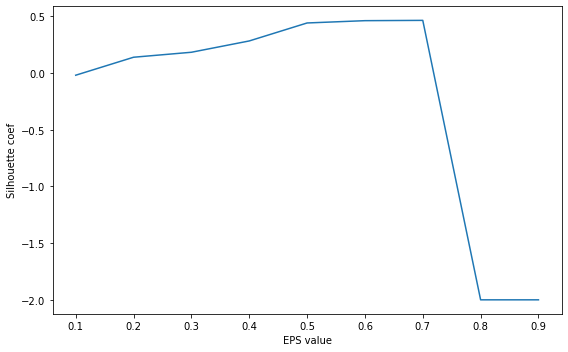

Best DBSCAN coeff 0.4656757482356441 at eps= 0.7000000000000001


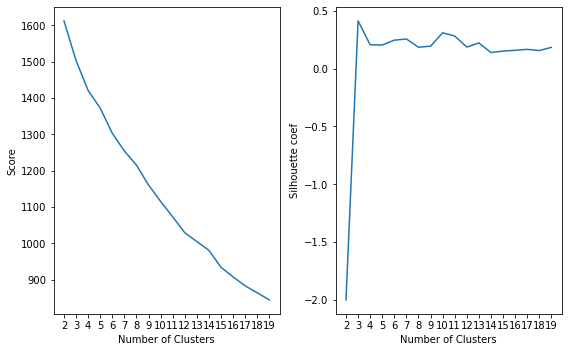

Best Kmeans coeff 0.4134443649026381 at K= 3
test printing: eps=0.7000000000000001, k=3
Estimated number of clusters dbs: 3
Estimated number of noise points dbs: 11
Silhouette Coefficient dbs: 0.466


,algo,Cluster,Restaurants,Count
0,kmeans,0,Pizza Place,24256
1,kmeans,0,Fast Food Restaurant,20808
2,kmeans,0,American Restaurant,17103
47,kmeans,1,Chinese Restaurant,141
78,kmeans,1,Ice Cream Shop,8
86,kmeans,1,Fast Food Restaurant,4
20,kmeans,2,American Restaurant,779
75,kmeans,2,Burger Joint,10
77,kmeans,2,Bakery,8
0,dbscan,0,Pizza Place,24256


In [23]:
pca_res_df, pca_res_results = run_benchmark(pca_df, 'pca_test')
pca_res_df

<h5>Test with data not choosen by pca:</h5>

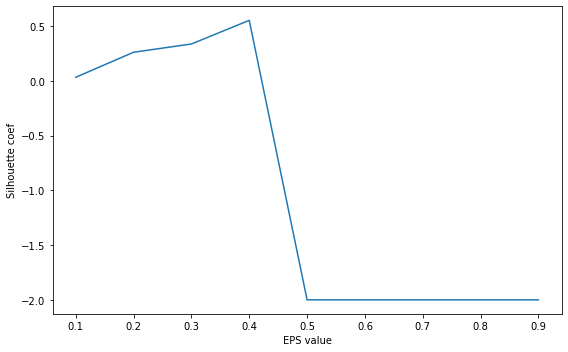

Best DBSCAN coeff 0.5527092412989423 at eps= 0.4


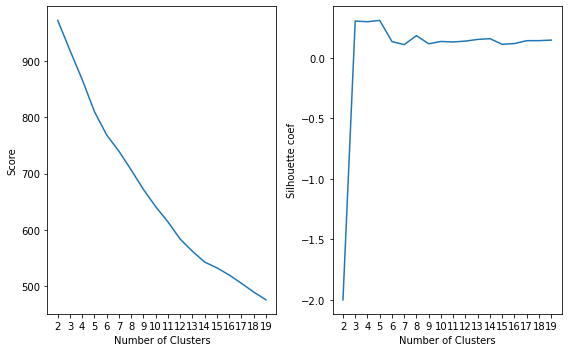

Best Kmeans coeff 0.31034095928904076 at K= 5
test printing: eps=0.4, k=5
Estimated number of clusters dbs: 7
Estimated number of noise points dbs: 135
Silhouette Coefficient dbs: 0.553


In [24]:
non_pca_df = pd.DataFrame(X_raw)
col = X_raw.columns[com95+1:-1]
non_pca_df = non_pca_df[col]

npca_res_df, npca_res_results = run_benchmark(non_pca_df, 'no_pca_test')

In [38]:
npca_res_df.head(30)
npca_res_df[npca_res_df['algo'] == 'dbscan']
#npca_res_df.to_csv('no_pca.csv', index=False)

,algo,Cluster,Restaurants,Count
0,dbscan,0,Pizza Place,24248
1,dbscan,0,Fast Food Restaurant,20803
2,dbscan,0,American Restaurant,17880
60,dbscan,1,Ice Cream Shop,32
67,dbscan,2,Gastropub,19
74,dbscan,3,Donut Shop,14
78,dbscan,4,Snack Place,12
79,dbscan,5,Southern / Soul Food Restaurant,10
73,dbscan,6,Steakhouse,14


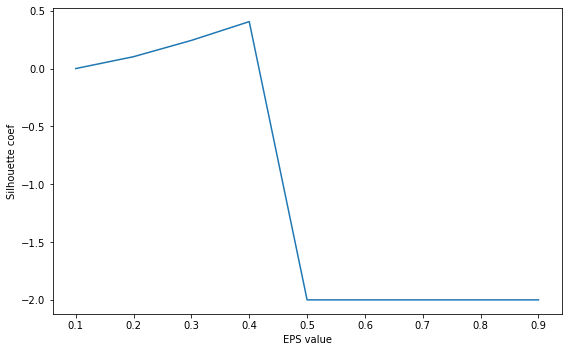

Best DBSCAN coeff 0.4059452069797498 at eps= 0.4


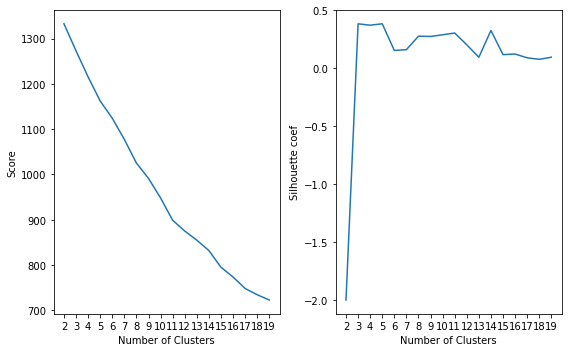

Best Kmeans coeff 0.3848050781520689 at K= 5
test printing: eps=0.4, k=5
Estimated number of clusters dbs: 14
Estimated number of noise points dbs: 259
Silhouette Coefficient dbs: 0.406


In [26]:
no_common_col = X_raw.columns
no_common_col = no_common_col.drop(['Pizza Place', 'American Restaurant', 'Fast Food Restaurant'])

no_common_res_df, no_common_res_results = run_benchmark(X_raw[no_common_col], 'no_common_test')

In [27]:
no_common_res_df

,algo,Cluster,Restaurants,Count
0,kmeans,0,Pizza Place,24237
1,kmeans,0,Fast Food Restaurant,20803
2,kmeans,0,American Restaurant,17814
48,kmeans,1,Chinese Restaurant,123
49,kmeans,2,Diner,122
78,kmeans,2,Pizza Place,16
84,kmeans,2,American Restaurant,10
44,kmeans,3,Deli / Bodega,183
83,kmeans,3,American Restaurant,10
91,kmeans,3,Bakery,6


<h5>Adding State and Cities</h5>
<p>
    In order to explore other way to segment the data I'm going to add cities and stated from the zip code data set.
    Using this iformation runing the same clustering algorithem we can test if this gouping do any better.
    Each time joining the city or state and runing the algorithem.
    Evaluating the result show no improvment over our basic idea of using zip codes
</p>

In [28]:
# marge dummies with state

In [29]:
temp = zipcodes_df[['Zip', 'City']]

resturants_grouped = dummies.groupby('ZipCode').sum().reset_index()

resturants_grouped = pd.merge(left=resturants_grouped, right=temp, how='left', left_on='ZipCode', right_on='Zip')

resturants_grouped.dropna(inplace=True)
# let drop all but resturnat type, zip code and house values
resturants_grouped = resturants_grouped.drop(columns=['Zip'])

In [30]:
group_state = resturants_grouped.groupby(by='City').mean().reset_index()

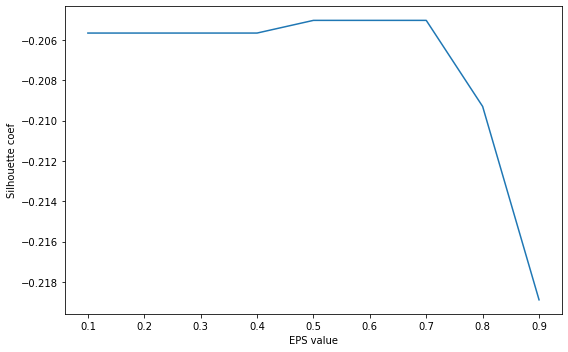

Best DBSCAN coeff -0.20502232660800337 at eps= 0.5


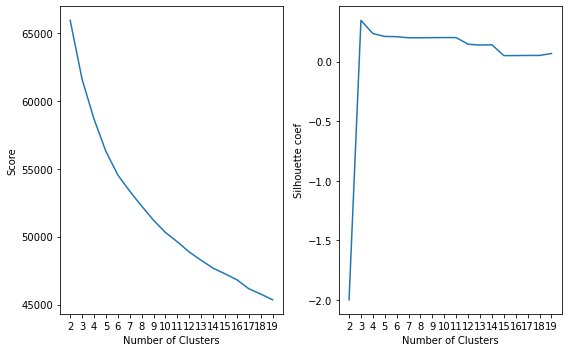

Best Kmeans coeff 0.34612649005247703 at K= 3
test printing: eps=0.5, k=3
Estimated number of clusters dbs: 18
Estimated number of noise points dbs: 2940
Silhouette Coefficient dbs: -0.205


ValueError: Length of values does not match length of index

In [31]:
city_g_df, city_g_results = run_benchmark(group_state.drop(columns=['City', 'ZipCode']), 'grouped_state_test')

In [ ]:
# print a summary statistics table

In [35]:
columns_res = ['test name', 'best_eps', 'dbscan clusters', 'dbscan noise', 'dbs - s_c', 'kmeasn clusters', 'kmeans s_c']
summary_df = pd.DataFrame([
    raw_res_results,
    pca_res_results,
    npca_res_results,
    no_common_res_results,
    #city_g_results,
], columns=columns_res)
summary_df

,test name,best_eps,dbscan clusters,dbscan noise,dbs - s_c,kmeasn clusters,kmeans s_c
0,raw_test,0.7,4,79,0.445821,3,0.396029
1,pca_test,0.7,3,11,0.465676,3,0.413444
2,no_pca_test,0.4,7,135,0.552709,5,0.310341
3,no_common_test,0.4,14,259,0.405945,5,0.384805
